In [1]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt


import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm

# Import the single DOF finite difference model MLP model
from mlp_singledof_lstm import MLP, MLPProjectionFilter, CustomLSTMLayer, LSTM_Hidden_State

/home/alinjar/simple_training_warm_start/lstm


In [2]:
def sample_uniform_trajectories(key, var_min, var_max, dataset_size, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=var_min,
        high=var_max,
        size=(dataset_size, nvar)
    )
    return xi_samples, rng

In [3]:
#Parameters for MLP model

num_batch = 1000
num_dof=1
num_steps=50
timestep=0.05
v_max=1.0
a_max=2.0
j_max=5.0
p_max=180.0*np.pi/180.0 
theta_init=0.0

# vmax = 1.0
# num_batch = 1000
# nvar = 1
nvar_single = num_steps
nvar = num_dof * nvar_single
theta_init_min=0.0
theta_init_max=2*np.pi


#calculating number of constraints
num_acc = num_steps - 1
num_jerk = num_acc - 1
num_pos = num_steps
num_vel_constraints = 2 * num_steps * num_dof
num_acc_constraints = 2 * num_acc * num_dof
num_jerk_constraints = 2 * num_jerk * num_dof
num_pos_constraints = 2 * num_pos * num_dof
num_total_constraints = (num_vel_constraints + num_acc_constraints + 
                            num_jerk_constraints + num_pos_constraints)
dataset_size = num_batch#200000

#Maximum Iterations
maxiter_projection = 20


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
#For training
theta_init, rng_theta_init = sample_uniform_trajectories(41, var_min= theta_init_min, var_max = theta_init_max, dataset_size=dataset_size, nvar=1)
#print("theta_init", theta_init.shape)
v_start, rng_v_start = sample_uniform_trajectories(40, var_min =-0.8*v_max, var_max = 0.8*v_max, dataset_size=dataset_size, nvar=1)
#print("v_start", v_start.shape)
v_goal, rng_v_goal = sample_uniform_trajectories(39, var_min =-0.8*v_max, var_max = 0.8*v_max, dataset_size=dataset_size, nvar=1)

## USe constant value of theta_init, v_start and v_goal for inference:

theta_init_scalar = 90.0*np.pi/180.0
v_start_scalar = 0.6
v_goal_scalar = -0.3
theta_init = np.tile(theta_init_scalar, (dataset_size,1))
v_start = np.tile(v_start_scalar, (dataset_size,1))
v_goal = np.tile(v_goal_scalar, (dataset_size,1))



#For training
xi_samples, rng = sample_uniform_trajectories(42, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)


inp = np.hstack(( xi_samples, theta_init, v_start, v_goal))



Using cuda device


In [5]:
#LSTM handling

lstm_input_size = 3*num_total_constraints+3*nvar

lstm_hidden_size = 512
# lstm_output_size = (2*nvar)**2+2*nvar
lstm_output_size = num_total_constraints+nvar
# lstm_context_size = mlp_planner_inp_dim

lstm_context = CustomLSTMLayer(lstm_input_size, lstm_hidden_size, lstm_output_size)


input_hidden_state_init = np.shape(inp)[1]
mid_hidden_state_init = 512
out_hidden_state_init = lstm_hidden_size

lstm_init  =  LSTM_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

##

enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints #( xi_samples- 0:nvar, lamda_smples- nvar:2*nvar)

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)



model = MLPProjectionFilter(mlp=mlp,lstm_context=lstm_context, lstm_init=lstm_init, num_batch = num_batch,num_dof=num_dof,num_steps=num_steps,
							timestep=timestep,v_max=v_max,a_max=a_max,j_max=j_max,p_max=p_max,
                            maxiter_projection=maxiter_projection).to(device)

print(type(model))

model.load_state_dict(torch.load('./training_weights/mlp_learned_single_dof_lstm.pth', weights_only=True))
model.eval()

<class 'mlp_singledof_lstm.MLPProjectionFilter'>


MLPProjectionFilter(
  (mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=53, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=1024, out_features=1024, bias=True)
      (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=1024, out_features=256, bias=True)
      (9): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (10): ReLU()
      (11): Dropout(p=0.2, inplace=False)
      (12): Linear(in_features=256, out_features=494, bias=True)
    )
  )
  (lstm_context): CustomLSTMLayer(
    (lstm_cell): LSTMCell(1332, 512)
    (output_transform): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=444, bias=True)
    )
  )
  (lstm_init): LSTM_Hidden_State

In [6]:
######
#Generate Test Data


inp_test = inp
inp_test = torch.tensor(inp_test).float()
inp_test = inp_test.to(device)
inp_mean = inp_test.mean()
inp_std = inp_test.std()
# inp_test = torch.vstack([inp_test] * num_batch)
inp_norm_test = (inp_test - inp_mean) / inp_std

xi_samples_input_nn_test = inp_test

theta_init_test = torch.from_numpy(theta_init).float().to(device)
v_start_test = torch.from_numpy(v_start).float().to(device)
v_goal_test = torch.from_numpy(v_goal).float().to(device)

with torch.no_grad():
    xi_projected, avg_res_fixed_point, avg_res_primal, res_primal_history, res_fixed_point_history = model.decoder_function(inp_norm_test, xi_samples_input_nn_test,
                                                                                                                            theta_init_test, v_start_test, 
                                                                                                                            v_goal_test)


In [7]:
# Convert to numpy for analysis
xi_np = np.array(xi_samples)
xi_filtered_np = np.array(xi_projected.cpu().detach().numpy())
prime_residuals_np = np.array(res_primal_history.cpu().detach().numpy())
fixed_residuals_np = np.array(res_fixed_point_history.cpu().detach().numpy())
# Print convergence statistics
print(f"\nConvergence Statistics:")
# print(f"Final primal residual - Mean: {np.mean(prime_residuals_np[-1]):.6f}, Max: {np.max(prime_residuals_np[-1]):.6f}")
# print(f"Final fixed point residual - Mean: {np.mean(fixed_residuals_np[-1]):.6f}, Max: {np.max(fixed_residuals_np[-1]):.6f}")

print(f"Prime residuals shape: {prime_residuals_np.shape}")
print(f"Fixed point residuals shape: {fixed_residuals_np.shape}")

#Save
os.makedirs('results_LSTM_inference', exist_ok=True)

#Start
print("Start")
print(f"Max Prime residuals start: {max(prime_residuals_np[0])}")
print(f"Max fixed residuals start: {max(fixed_residuals_np[0])}")
print(f"Min Prime residuals start: {min(prime_residuals_np[0])}")
print(f"Min fixed residuals start: {min(fixed_residuals_np[0])}")

#End
print("End")
print(f"Max Prime residuals end: {max(prime_residuals_np[-1])}")
print(f"Max fixed residuals end: {max(fixed_residuals_np[-1])}")
print(f"Min Prime residuals end: {min(prime_residuals_np[-1])}")
print(f"Min fixed residuals end: {min(fixed_residuals_np[-1])}")


np.savetxt('results_LSTM_inference/original_trajectory.csv', xi_np, delimiter=',')  # Save first sample
np.savetxt('results_LSTM_inference/projected_trajectory.csv', xi_filtered_np, delimiter=',')
np.savetxt('results_LSTM_inference/prime_residuals.csv', prime_residuals_np, delimiter=',')
np.savetxt('results_LSTM_inference/fixed_residuals.csv', fixed_residuals_np, delimiter=',')


Convergence Statistics:
Prime residuals shape: (20, 1000)
Fixed point residuals shape: (20, 1000)
Start
Max Prime residuals start: 0.0
Max fixed residuals start: 63.082950592041016
Min Prime residuals start: 0.0
Min fixed residuals start: 62.22388458251953
End
Max Prime residuals end: 0.0
Max fixed residuals end: 0.662983238697052
Min Prime residuals end: 0.0
Min fixed residuals end: 0.3234553933143616


In [8]:
#plot
#print("P_pos", opt_class.P_pos)

P_pos_np = model.P_pos.cpu().detach().numpy()
print("P_pos", P_pos_np.shape)
print("xi_pos", xi_filtered_np.shape)
pos = (P_pos_np @ xi_filtered_np.T).T #model.theta_init*np.ones((xi_filtered_np.shape[0], P_pos_np.shape[0]))
pos_np = np.asarray(pos)
#print("pos_np", pos_np)

P_pos (50, 50)
xi_pos (1000, 50)


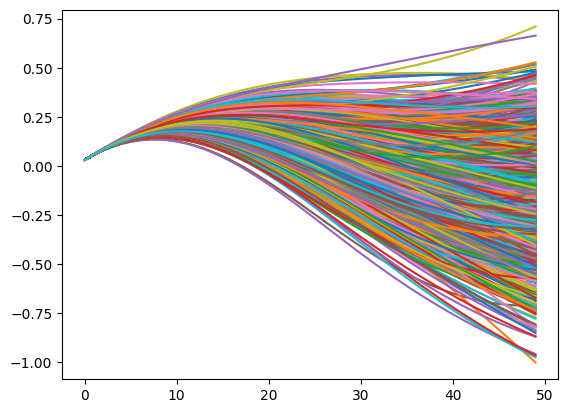

In [9]:
%matplotlib inline
plt.figure(1)
plt.plot(pos_np.T)
plt.show()

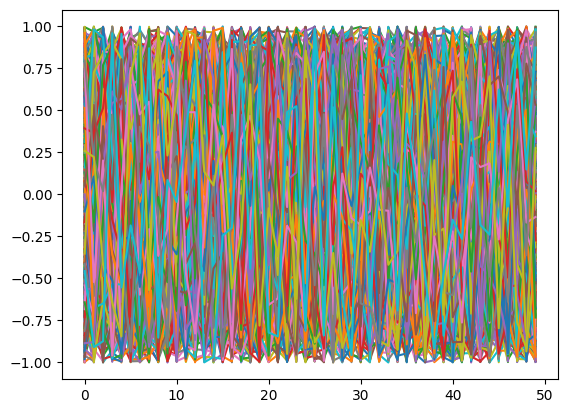

In [10]:
%matplotlib inline
plt.figure(2)
plt.plot(xi_np.T)
plt.show()

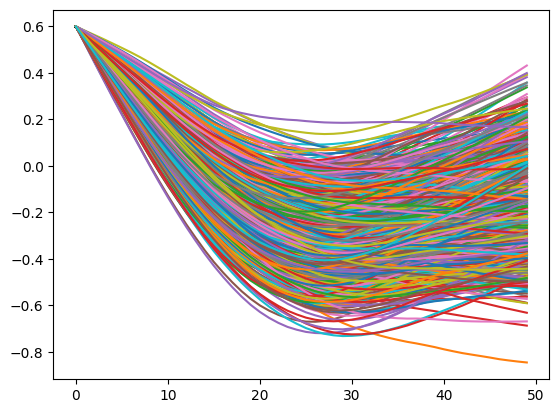

In [11]:

%matplotlib inline
plt.figure(3)
plt.plot(xi_filtered_np.T)
plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_trajectory(original, projected, dof_idx=0, dof=1, dt=0.05):
    """Visualize original and residual trajectories separately for a specific DOF"""
    
    num_steps = original.shape[0] // dof
    
    # Extract velocities for the specified DOF
    orig_vel = original[dof_idx*num_steps : (dof_idx+1)*num_steps]
    proj_vel = projected[dof_idx*num_steps : (dof_idx+1)*num_steps]
    
    # Calculate residual velocity (original - projected)
    filtered_vel = proj_vel
    
    # Create time vector
    time = np.arange(num_steps) * dt
    
    # Plot original velocity
    plt.figure(figsize=(10, 4))
    plt.plot(time, orig_vel, 'b-')
    plt.axhline(y=1.0, color='g', linestyle='--', label='v_max')
    plt.axhline(y=-1.0, color='g', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel(f'Joint {dof_idx} Velocity')
    plt.title(f'Original Joint {dof_idx} Velocity')
    plt.legend()
    plt.grid(True)
    try:
        plt.show()
    except:
        plt.savefig(f"original_trajectory_dof{dof_idx}.png")
        print(f"Original plot saved as original_trajectory_dof{dof_idx}.png")
    
    # Plot residual velocity
    plt.figure(figsize=(10, 4))
    plt.plot(time, filtered_vel, 'm-')
    plt.axhline(y=0.0, color='k', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel(f'Joint {dof_idx} Filtered Velocity')
    plt.title(f'Filtered Velocity for Joint {dof_idx}')
    plt.legend()
    plt.grid(True)
    try:
        plt.show()
    except:
        plt.savefig(f"residual_trajectory_dof{dof_idx}.png")
        print(f"Residual plot saved as residual_trajectory_dof{dof_idx}.png")


def visualize_residuals(residuals):
    """Visualize residuals across iterations for a specific batch sample"""
    
    # residuals shape: (maxiter_projection, num_batch)
    # Extract residuals for specific batch sample
    
    residuals_sample = residuals
    
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(residuals_sample, 'b-', marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Residual')
    plt.title(f'ADMM Residuals Convergence )')
    plt.grid(True)
    
    try:
        plt.show()
    except:
        plt.savefig(f"residuals_batch.png")
        print(f"Residuals plot saved as residuals_batch.png")
        


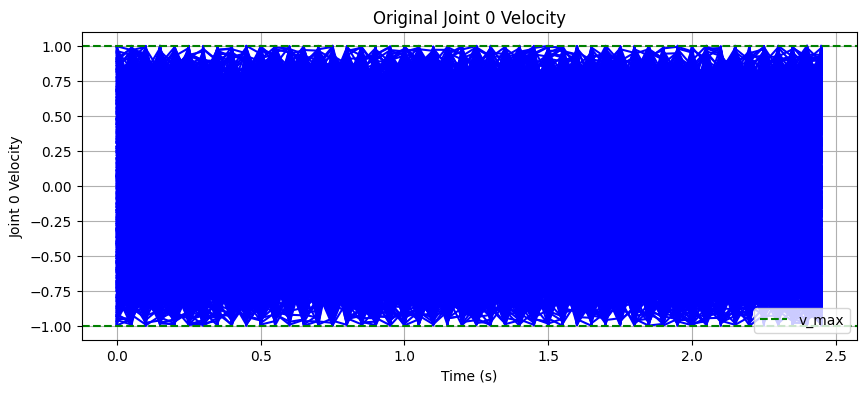

/tmp/ipykernel_1189929/2421631824.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


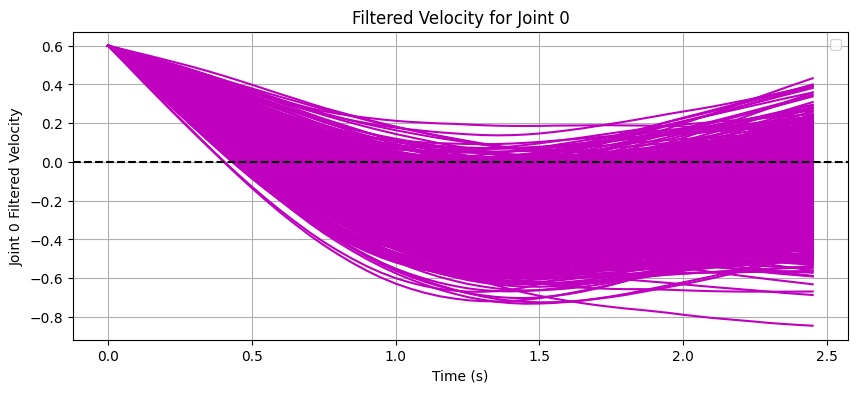

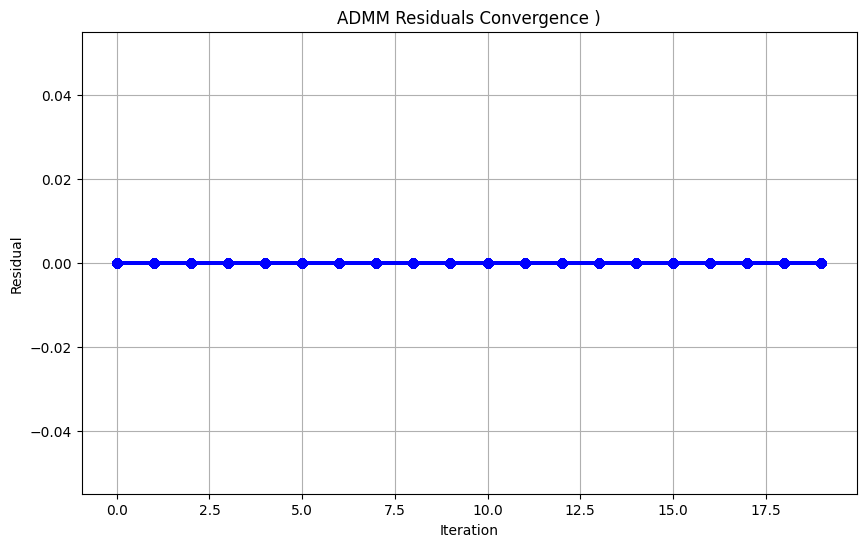

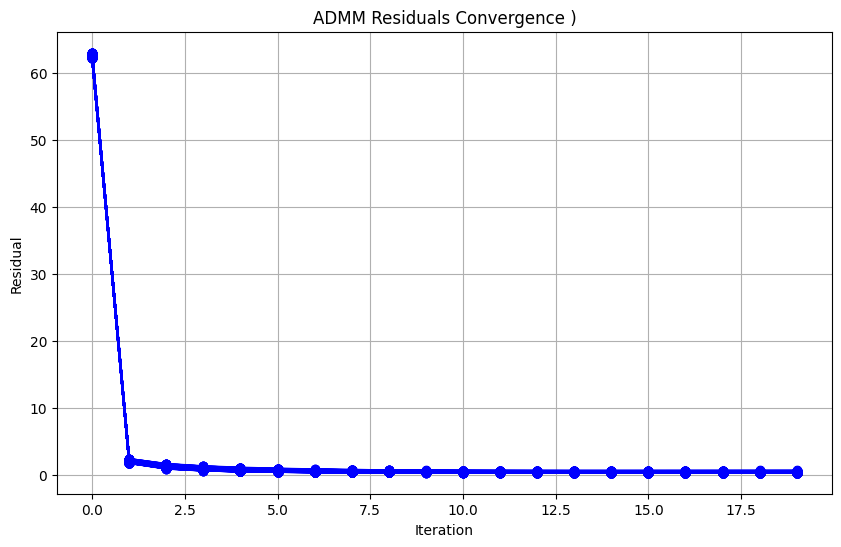

In [13]:
%matplotlib inline
visualize_trajectory(xi_np.T, xi_filtered_np.T, dof_idx=0, dof=1, dt=0.05)
visualize_residuals(prime_residuals_np)
visualize_residuals(fixed_residuals_np)